<a href="https://colab.research.google.com/github/gsarm78/cs230Project/blob/master/models/model3_unet/Small_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nowcasting using U-Net architecture**

The basic architecture is an encoder-decoder pair with skip connections to combine low-level feature maps with higher-level ones. 

Pros:
*   Has good performance.
*   Can work with less labeled data.
*   Typically scaled invariant (can work with multiple input sizes) as there are no dense layers.



In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

**Input Data & Preprocessing**

**MODEL**

In [0]:
img_rows = 512
img_cols = 512

In [0]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory
# Notice for donw/upsampling to work, image res must be divisible by 2^n, where n= maxpool layers

# TODO:
## Use: kernel_initializer='he_normal'
##

def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    #drop4 = Dropout(0.5)(conv4)   
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)  ## If dropout change conv4->drop4  ## Four maxpool convs for downsampling reducing resolution by half, for 4 times

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    #Deconvolution & upsamples the image back to its original resolution.
    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='linear')(conv9)  #not Sigmoid as it will give Segmentation
    output = conv10

    model = Model(inputs=inputs, outputs=output)

    return model

In [0]:
model = get_small_unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Use DICE coefficient**:

Dice is a measure of overlap between two samples. It ranges from 0 to 1 , where a Dice coefficient of 1 denotes perfect and complete overlap. 
The Dice coefficient can be calculated as:

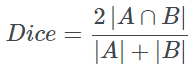

where |A∩B| represents the common elements between sets A and B, and |A| represents the number of elements in set A (and likewise for set B).

In [0]:
#Define DICE 
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [0]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [0]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

**Performance**

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

**Prediction on Test data**

In [0]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

In [0]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

In [0]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

In [0]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

In [0]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])